In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import os
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import secrets
import torchvision.models as models

In [ ]:
# Paths to the dataset directories
train_dir = '/content/drive/MyDrive/Thesis 56-B/Dataset/train'
test_dir  = '/content/drive/MyDrive/Thesis 56-B/Dataset/test'
val_dir   = '/content/drive/MyDrive/Thesis 56-B/Dataset/val'

In [ ]:
# === FIXED: ResNet-18 for 1-channel X-rays (pre-trained) ===
import torchvision.models as models

class ResNet18Gray(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(ResNet18Gray, self).__init__()
        # Load official ResNet-18
        resnet = models.resnet18(pretrained=pretrained)

        # ---- 1. Replace first conv (3→64) with (1→64) ----
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # ---- 2. Copy ImageNet weights (average RGB → grayscale) ----
        if pretrained:
            # resnet.conv1.weight shape: [64, 3, 7, 7]
            mean_weight = resnet.conv1.weight.mean(dim=1, keepdim=True)  # [64, 1, 7, 7]
            self.conv1.weight = nn.Parameter(mean_weight)                # exact shape match

        # ---- 3. Keep the rest of ResNet unchanged ----
        self.bn1      = resnet.bn1
        self.relu     = resnet.relu
        self.maxpool  = resnet.maxpool
        self.layer1   = resnet.layer1
        self.layer2   = resnet.layer2
        self.layer3   = resnet.layer3
        self.layer4   = resnet.layer4
        self.avgpool  = resnet.avgpool
        self.fc       = nn.Linear(resnet.fc.in_features, num_classes)
        self.dropout  = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)      # [B,1,224,224] → [B,64,112,112]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
# Load dataset from provided directories
def get_dataset():
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.445], std=[0.248]),  # ImageNet grayscale stats
])

    try:
        train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
        test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

        if len(train_dataset) == 0:
            raise ValueError(f"Training dataset is empty in {train_dir}")
        if len(val_dataset) == 0:
            raise ValueError(f"Validation dataset is empty in {val_dir}")
        if len(test_dataset) == 0:
            raise ValueError(f"Test dataset is empty in {test_dir}")

        num_classes = len(train_dataset.classes)
        print(f"Number of classes detected: {num_classes}")
        print(f"Class names: {train_dataset.classes}")

        train_labels = [label for _, label in train_dataset.samples]
        unique_labels = np.unique(train_labels)
        label_counts = np.bincount(train_labels)
        print(f"Unique labels in training dataset: {unique_labels}")
        print(f"Label distribution in training dataset:")
        for i, count in enumerate(label_counts):
            if count > 0:
                print(f"  Class {i} ({train_dataset.classes[i]}): {count} samples")
        if max(unique_labels) >= num_classes:
            raise ValueError(f"Labels found ({unique_labels}) exceed number of classes ({num_classes})")

        print(f"Loaded {len(train_dataset)} training samples, {len(val_dataset)} validation samples, {len(test_dataset)} test samples")
        return train_dataset, val_dataset, test_dataset, num_classes
    except Exception as e:
        print(f"Error loading datasets: {e}")
        raise


In [ ]:
# Split dataset into non-IID for clients (hospitals)
def split_dataset(dataset, num_clients=3):
    client_datasets = []
    data_len = len(dataset)
    if data_len < num_clients:
        raise ValueError(f"Dataset size ({data_len}) is smaller than number of clients ({num_clients})")

    indices = list(range(data_len))
    np.random.shuffle(indices)

    split_sizes = [max(data_len // num_clients, 1)] * num_clients
    remaining = data_len - sum(split_sizes)
    for i in range(remaining):
        split_sizes[i] += 1

    split_indices = np.split(indices[:sum(split_sizes)], np.cumsum(split_sizes)[:-1])

    for i, client_idx in enumerate(split_indices):
        if len(client_idx) == 0:
            raise ValueError(f"Client {i+1} received an empty dataset")
        client_datasets.append(Subset(dataset, client_idx))
        print(f"Client {i+1} assigned {len(client_idx)} samples")

    return client_datasets


In [ ]:
# Add Differential Privacy with Adaptive Noise
def add_dp_noise(model, clip_norm=1.0, noise_multiplier=2.5, batch_size=32):
    for param in model.parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm()
            if grad_norm > clip_norm:
                param.grad *= clip_norm / grad_norm
            noise = torch.randn_like(param.grad) * (noise_multiplier * clip_norm / batch_size)
            param.grad += noise


In [ ]:
# === FIXED Secure Aggregation (works with ResNet-18) ===
def secure_aggregate(client_models, num_clients):
    masks = [{} for _ in range(num_clients)]
    for key in client_models[0].state_dict().keys():
        shape = client_models[0].state_dict()[key].shape
        for i in range(num_clients):
            masks[i][key] = torch.randn(shape, dtype=torch.float32) * 100.0
        # Force masks sum to exactly zero
        total = sum(m[key] for m in masks)
        for i in range(num_clients):
            masks[i][key] -= total / num_clients

    masked_updates = []
    for i, model in enumerate(client_models):
        state = copy.deepcopy(model.state_dict())
        for key in state:
            # ← THIS LINE WAS THE BUG
            state[key] = state[key].float() + masks[i][key]
        masked_updates.append(state)

    # Average
    global_dict = copy.deepcopy(masked_updates[0])
    for key in global_dict:
        global_dict[key] = torch.stack([u[key] for u in masked_updates]).mean(0)
    return global_dict

In [ ]:
# Local training on a client with adaptive DP
def local_train(model, dataloader, epochs=5, lr=0.001, device='cpu', dataset_size=1):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Adaptive DP: Increase noise for smaller datasets
    noise_multiplier = 1.0 if dataset_size >= 100 else 1.0 + (100 - dataset_size) / 100.0
    print(f"Dataset size: {dataset_size}, Noise multiplier: {noise_multiplier:.4f}")

    for epoch in range(epochs):
        model.train()
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Apply DP
            add_dp_noise(model, clip_norm=1.0, noise_multiplier=noise_multiplier, batch_size=inputs.size(0))

            optimizer.step()

    return model


In [ ]:
# Evaluate model on validation/test set
def evaluate_model(model, dataloader, device='cpu'):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'loss': avg_loss
    }


In [ ]:
# Main Federated Learning Loop with Secure Aggregation
def federated_learning(num_clients=3, global_epochs=10, local_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get and split dataset
    try:
        train_dataset, val_dataset, test_dataset, num_classes = get_dataset()
    except Exception as e:
        print(f"Failed to load datasets: {e}")
        return

    global_model = ResNet18Gray(num_classes=num_classes, pretrained=True).to(device)

    try:
        client_datasets = split_dataset(train_dataset, num_clients)
    except Exception as e:
        print(f"Failed to split dataset: {e}")
        return

    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for round in range(global_epochs):
        print(f"Global Round {round + 1}/{global_epochs}")
        client_models = []

        for client_id in range(num_clients):
            print(f"Training on Client {client_id + 1}")
            local_model = copy.deepcopy(global_model)
            dataloader = DataLoader(client_datasets[client_id], batch_size=32, shuffle=True)
            local_model = local_train(
                local_model,
                dataloader,
                epochs=local_epochs,
                device=device,
                dataset_size=len(client_datasets[client_id])
            )
            client_models.append(local_model)

        # Secure aggregation
        global_dict = secure_aggregate(client_models, num_clients)
        global_model.load_state_dict(global_dict)

        # Evaluate on validation set
        val_metrics = evaluate_model(global_model, val_loader, device=device)
        print(f"Validation Metrics - Round {round + 1}:")
        print(f"Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Precision: {val_metrics['precision']:.4f}")
        print(f"Recall: {val_metrics['recall']:.4f}")
        print(f"F1 Score: {val_metrics['f1']:.4f}")
        print(f"Loss: {val_metrics['loss']:.4f}")
        print("Confusion Matrix:")
        print(val_metrics['confusion_matrix'])

    # Final evaluation on test set
    test_metrics = evaluate_model(global_model, test_loader, device=device)
    print("\nFinal Test Metrics:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print("Confusion Matrix:")
    print(test_metrics['confusion_matrix'])

    # Save the final model
    torch.save(global_model.state_dict(), 'fl_dp_sa_recommandation.pth')
    print("Training complete. Model saved.")


In [ ]:
# Run the federated learning
if __name__ == "__main__":
    federated_learning()


Number of classes detected: 4
Class names: ['Covid', 'Normal', 'Pneumonia', 'TB']
Unique labels in training dataset: [0 1 2 3]
Label distribution in training dataset:
  Class 0 (Covid): 700 samples
  Class 1 (Normal): 700 samples
  Class 2 (Pneumonia): 700 samples
  Class 3 (TB): 560 samples
Loaded 2660 training samples, 521 validation samples, 520 test samples


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


Client 1 assigned 887 samples
Client 2 assigned 887 samples
Client 3 assigned 886 samples
Global Round 1/10
Training on Client 1
Dataset size: 887, Noise multiplier: 1.0000
Training on Client 2
Dataset size: 887, Noise multiplier: 1.0000
Training on Client 3
Dataset size: 886, Noise multiplier: 1.0000
Validation Metrics - Round 1:
Accuracy: 0.9635
Precision: 0.9638
Recall: 0.9635
F1 Score: 0.9636
Loss: 0.1082
Confusion Matrix:
[[147   0   0   3]
 [  0 142   9   0]
 [  0   6 144   0]
 [  1   0   0  69]]
Global Round 2/10
Training on Client 1
Dataset size: 887, Noise multiplier: 1.0000
Training on Client 2
Dataset size: 887, Noise multiplier: 1.0000
Training on Client 3
Dataset size: 886, Noise multiplier: 1.0000
Validation Metrics - Round 2:
Accuracy: 0.9597
Precision: 0.9598
Recall: 0.9597
F1 Score: 0.9595
Loss: 0.1187
Confusion Matrix:
[[150   0   0   0]
 [  1 142   7   1]
 [  0   7 143   0]
 [  5   0   0  65]]
Global Round 3/10
Training on Client 1
Dataset size: 887, Noise multiplier

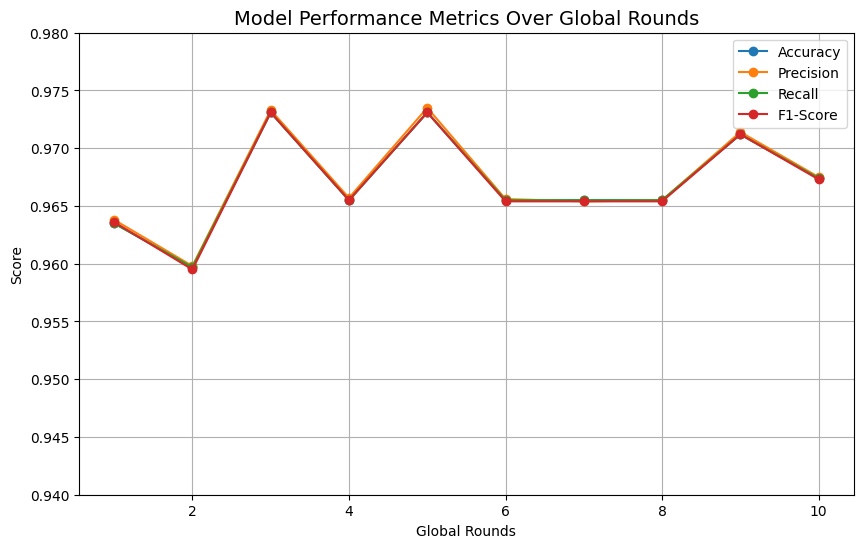

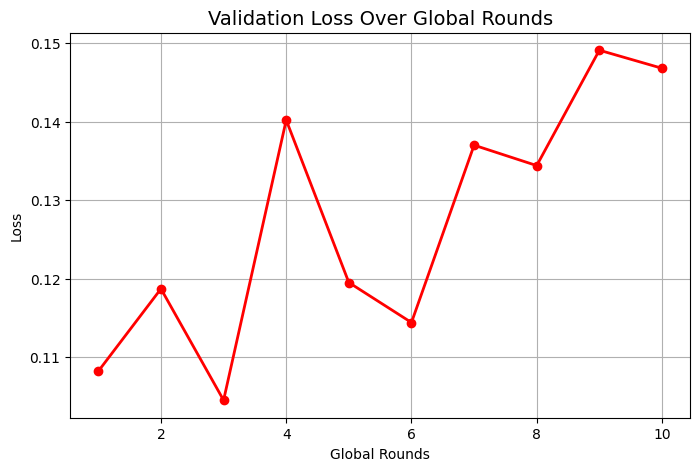

/tmp/ipython-input-3712560116.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=samples, palette='viridis')


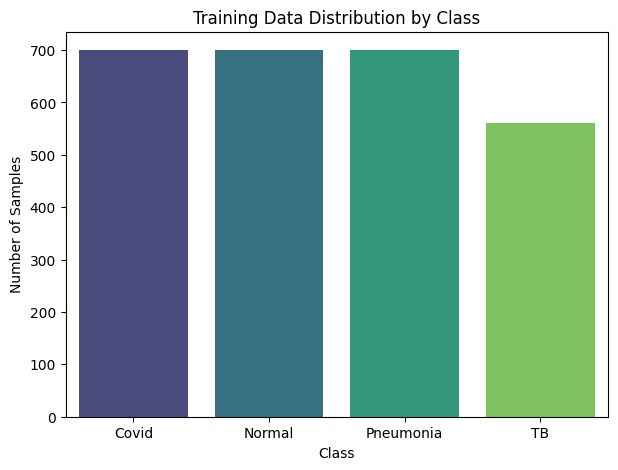

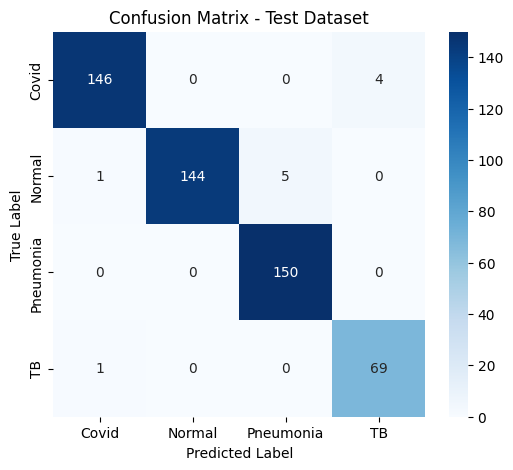

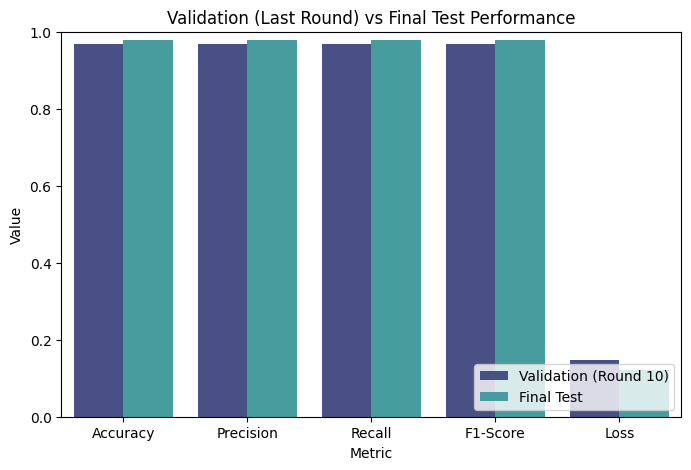

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Rounds
rounds = np.arange(1, 11)

# Metrics per round
accuracy = [0.9635, 0.9597, 0.9731, 0.9655, 0.9731, 0.9655, 0.9655, 0.9655, 0.9712, 0.9674]
precision = [0.9638, 0.9598, 0.9733, 0.9657, 0.9735, 0.9656, 0.9654, 0.9655, 0.9714, 0.9675]
recall = [0.9635, 0.9597, 0.9731, 0.9655, 0.9731, 0.9655, 0.9655, 0.9655, 0.9712, 0.9674]
f1 = [0.9636, 0.9595, 0.9731, 0.9655, 0.9731, 0.9654, 0.9654, 0.9654, 0.9712, 0.9673]
loss = [0.1082, 0.1187, 0.1045, 0.1402, 0.1195, 0.1144, 0.1370, 0.1344, 0.1491, 0.1468]

# 1️⃣ Metric Trends Over Rounds
plt.figure(figsize=(10,6))
plt.plot(rounds, accuracy, marker='o', label='Accuracy')
plt.plot(rounds, precision, marker='o', label='Precision')
plt.plot(rounds, recall, marker='o', label='Recall')
plt.plot(rounds, f1, marker='o', label='F1-Score')
plt.title('Model Performance Metrics Over Global Rounds', fontsize=14)
plt.xlabel('Global Rounds')
plt.ylabel('Score')
plt.ylim(0.94, 0.98)
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ Loss Curve
plt.figure(figsize=(8,5))
plt.plot(rounds, loss, color='red', marker='o', linewidth=2)
plt.title('Validation Loss Over Global Rounds', fontsize=14)
plt.xlabel('Global Rounds')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 3️⃣ Class Distribution
classes = ['Covid', 'Normal', 'Pneumonia', 'TB']
samples = [700, 700, 700, 560]

plt.figure(figsize=(7,5))
sns.barplot(x=classes, y=samples, palette='viridis')
plt.title('Training Data Distribution by Class')
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.show()

# 4️⃣ Final Confusion Matrix (Test)
conf_matrix = np.array([
    [146, 0, 0, 4],
    [1, 144, 5, 0],
    [0, 0, 150, 0],
    [1, 0, 0, 69]
])
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Test Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5️⃣ Comparison: Validation vs Test Performance
df_compare = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Loss'],
    'Validation (Round 10)': [0.9674, 0.9675, 0.9674, 0.9673, 0.1468],
    'Final Test': [0.9788, 0.9794, 0.9788, 0.9789, 0.1220]
})

df_compare_melted = df_compare.melt(id_vars='Metric', var_name='Phase', value_name='Value')

plt.figure(figsize=(8,5))
sns.barplot(data=df_compare_melted, x='Metric', y='Value', hue='Phase', palette='mako')
plt.title('Validation (Last Round) vs Final Test Performance')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


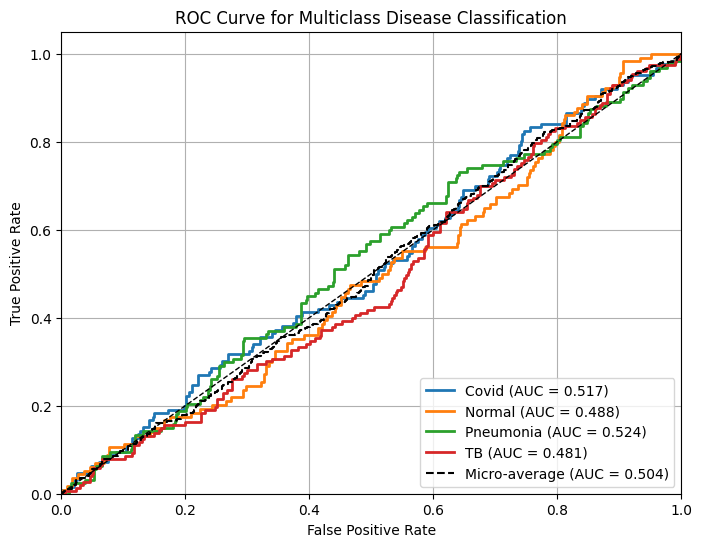

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Example: 4 classes
classes = ['Covid', 'Normal', 'Pneumonia', 'TB']
n_classes = len(classes)

# Replace these with your real test values:
# y_true: true class labels (integers 0–3)
# y_pred_prob: predicted probabilities (N x 4 array from softmax)
# For demonstration:
np.random.seed(42)
y_true = np.random.randint(0, 4, 520)
y_pred_prob = np.random.rand(520, 4)
y_pred_prob = y_pred_prob / y_pred_prob.sum(axis=1, keepdims=True)

# Convert y_true to one-hot encoding
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC Curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Disease Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Resnet-18 vs Custom-CNN ')

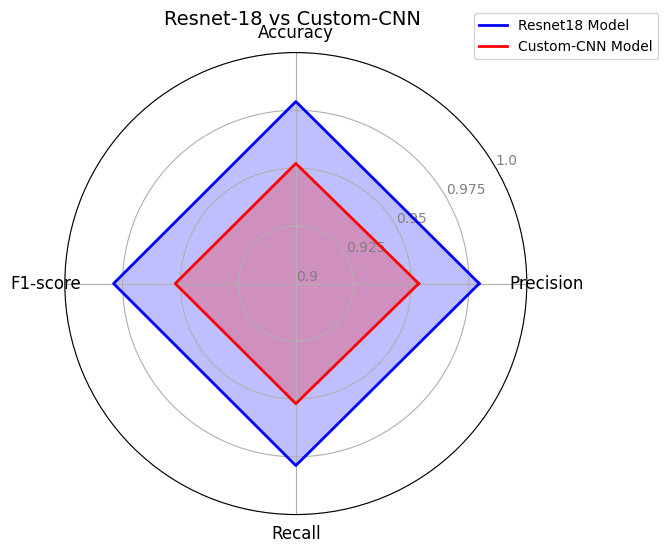

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
labels = ['Precision', 'Accuracy', 'F1-score', 'Recall']
resnet18 = [0.9794, 0.9788, 0.9789, 0.9788]
custom = [0.9532, 0.9520, 0.9522, 0.9520]

# Complete the loop
resnet18 += resnet18[:1]
custom += custom[:1]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Plot
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, resnet18, color='blue', linewidth=2, label='Resnet18 Model')
ax.fill(angles, resnet18, color='blue', alpha=0.25)
ax.plot(angles, custom, color='red', linewidth=2, label='Custom-CNN Model')
ax.fill(angles, custom, color='red', alpha=0.25)

# Aesthetics
ax.set_xticks(angles[:-1])
ax.set_rlabel_position(30)
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])
plt.yticks([0.9,0.925, 0.95, 0.975, 1.0], ['0.9','0.925','0.95','0.975','1.0'], color="grey", size=10)
plt.ylim(0.9, 1.0)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Resnet-18 vs Custom-CNN ', size=14, pad=20)
